In [1]:
%matplotlib notebook

import IPython.display
import numpy as np
import tensorflow as tf
import PIL
import subprocess
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
s = tf.Session()

In [3]:
n = 500

In [4]:
rnd_gen = tf.random_uniform((n, 3), dtype=tf.float64)

In [5]:
y = tf.Variable(rnd_gen, dtype=tf.float64, trainable=True)

In [6]:
yyt = tf.matmul(y, tf.transpose(y))
sqlen = tf.matrix_diag_part(yyt)
trp = tf.tile(tf.reshape(sqlen, [1, -1]), [n, 1])
trq = tf.tile(tf.reshape(sqlen, [-1, 1]), [1, n])
qlenbetween = -yyt * 2 + trq + trp + tf.eye(n, dtype=tf.float64)
potentials = 1 / tf.sqrt(qlenbetween) - tf.eye(n, dtype=tf.float64)
global_potent = tf.reduce_sum(potentials) + 10 * tf.norm(sqlen - tf.fill((n,), tf.constant(1, dtype=tf.float64)), ord=2)

In [7]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.1, global_step, 500, 0.95, staircase=True)

In [8]:
s.run(tf.global_variables_initializer())

In [9]:
s.run(global_potent)

465054.3615381124

In [10]:
!! rm imgs/*.png

["rm: cannot remove 'imgs/*.png': No such file or directory"]

In [11]:
g_o = tf.train.GradientDescentOptimizer(learning_rate)
step = g_o.minimize(global_potent, global_step)

In [12]:
for iter_num in range(200):
    prev = s.run(global_potent)
    for _ in range(100):
        s.run(step)
    current = s.run(global_potent)
    IPython.display.clear_output()
    IPython.display.display(
        'iteration {} done. l_r = {} global_potent = {} diff = {}'
        .format(iter_num, s.run(learning_rate), current, current - prev))

'iteration 199 done. l_r = 0.012851208448410034 global_potent = 43277.13366367077 diff = -0.00017495291831437498'

In [18]:
def show_povray_picture():
    data = s.run([y])[0]
    h, w = data.shape
    with open('points.pov', 'w') as dst:
        for p in range(h):
            xx = data[p][0]
            yy = data[p][1]
            zz = data[p][2]
            print('sphere {{< {}, {}, {}> .1 pigment {{color<1,0,0>}}}}'.format(xx, yy, zz), file=dst)
    angle = 0.1
    with open('cam_angle.pov', 'w') as dst:
        angle_def = '#declare cam_angle = {};\n'.format(0.70 + angle/100)
        dst.write(angle_def)
    out_flnm = 'imgs/img_uniq.png'
    povray_process = subprocess.Popen(['povray', 'cube.pov', '-O'+out_flnm, '-D0'],
                                     stderr=subprocess.PIPE,
                                     stdout=subprocess.PIPE)
    err_code = povray_process.communicate()
    if povray_process.returncode:
        print(err_code[1].decode('utf-8'))
        return
    IPython.display.clear_output()
    IPython.display.display(PIL.Image.open(out_flnm))    

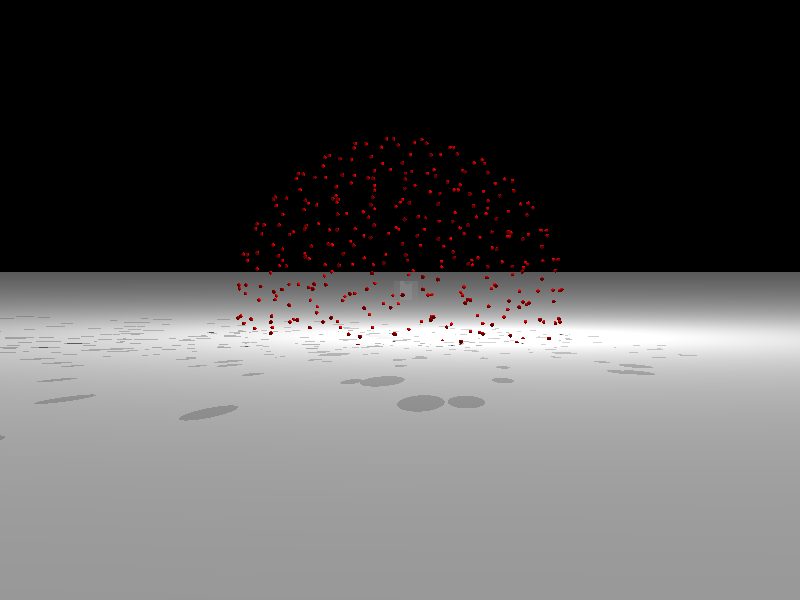

In [22]:
show_povray_picture()

In [13]:
def train_with_pictures():
    for iter_num in range(200):
        angle += 0.5
        prev = s.run(global_potent)
        for _ in range(10):
            s.run(step)
        current = s.run(global_potent)
        data = s.run([y])[0]
        h, w = data.shape
        with open('points.pov', 'w') as dst:
            for p in range(h):
                xx = data[p][0]
                yy = data[p][1]
                zz = data[p][2]
                print('sphere {{< {}, {}, {}> .1 pigment {{color<1,0,0>}}}}'.format(xx, yy, zz), file=dst)

        with open('cam_angle.pov', 'w') as dst:
            angle_def = '#declare cam_angle = {};\n'.format(0.70 + angle/100)
            dst.write(angle_def)
        out_flnm = 'imgs/img_{:04}.png'.format(meter)
        povray_process = subprocess.Popen(['povray', 'cube.pov', '-O'+out_flnm, '-D0'],
                                         stderr=subprocess.PIPE,
                                         stdout=subprocess.PIPE)
        err_code = povray_process.communicate()
        if povray_process.returncode:
            print(err_code[1].decode('utf-8'))
            break
        meter += 1
        IPython.display.clear_output()
        IPython.display.display(
            'iteration {} done. l_r = {} global_potent = {} diff = {}'
            .format(meter, s.run(learning_rate), current, current - prev))
        IPython.display.display(PIL.Image.open(out_flnm))    

In [14]:
def show_picture():
    data = s.run([y])[0]

    plt.figure(figsize=(10, 10))
    ax=plt.axes(projection='3d')
    ax.view_init(10,45)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    xx=data[:, 0]
    yy=data[:, 1]
    zz=data[:, 2]
    dx=max(xx)-min(xx)
    dy=max(yy)-min(yy)
    dz=max(zz)-min(zz)
    dcommon = max(dx, dy, dz)
    mx = (max(xx)+min(xx))/2
    my = (max(yy)+min(yy))/2
    mz = (max(zz)+min(zz))/2
    ax.set_xlim3d((mx-dcommon/2,mx+dcommon/2))
    ax.set_ylim3d((my-dcommon/2,my+dcommon/2))
    ax.set_zlim3d((mz-dcommon/2,mz+dcommon/2))
    ax.scatter(xx,yy,zz)
    plt.show()

In [ ]:
g_o = tf.train.AdamOptimizer()
step = g_o.minimize(global_potent)

In [ ]:
g_o = tf.train.MomentumOptimizer(0.000001, 0.3)
step = g_o.minimize(global_potent)

In [ ]:
prev = s.run(global_potent)
for _ in range(100):
    s.run([step])
current = s.run(global_potent)
'{} -> {} with diff {}'.format(prev, current, current - prev)

#### Два гаусса

In [ ]:
first_class = tf.distributions.Normal(loc=(3., 0., 0.), scale=(.3, .3, .3))
second_class = tf.distributions.Normal(loc=(0., 3., 0.), scale=(.3, .3, .3))


first_class_samples = first_class.sample(1000)
second_class_samples = second_class.sample(900)

first_class_samples_values, second_class_samples_values = s.run([first_class_samples, second_class_samples])

first_class_y = tf.constant(1.0, dtype=tf.float32, shape=(first_class_samples.get_shape()[0], 1))
second_class_y = tf.constant(0.0, dtype=tf.float32, shape=(second_class_samples.get_shape()[0], 1))

first_data = tf.concat((first_class_samples, first_class_y), 1)
second_data = tf.concat((second_class_samples, second_class_y), 1)

data = tf.random_shuffle(tf.concat((first_data, second_data), 0))

#### Нарисовать выборки из двух гауссов

In [ ]:
povray_script_declares =\
'''#version 3.7;

global_settings {assumed_gamma 1.0}

#declare dist = 10;
// #declare cam_angle = 0.05;
#declare data_x = 1.5;
#declare data_y = 1.5;
#declare data_z = 0;
'''

povray_script_code ='''
camera {
  location <data_x + dist * cos(2 * pi * cam_angle), data_z + 1.5, data_y + dist * sin( 2 * pi * cam_angle)>
  look_at <data_x, data_z, data_y>
  angle 40
}

light_source {
  <5, 10, 5>
  color <1, 1, 1>
}

light_source {
  <5, 10, -5>
  color <1, 1, 1>
}

box {
  <0, 0, 0>
  <1, 1, 1>
  
  pigment {
    color <1, 1, 1>
    filter 0.8
  }
}

plane {
  <0, 1, 0>, -2
  pigment {
    color <1,1,1>
  }
}

'''

def swap_yz(v):
    return (v[t] for t in [0, 2, 1])

def print_sphere(pos, r, color):
    return 'sphere {{< {}, {}, {}> {} pigment {{color<{}, {}, {}>}}}}\n'\
           .format(*swap_yz(pos), r, *color)
    
def print_disc(pos, norm, r):
    return 'disc {{< {}, {}, {} > < {}, {}, {}> {} }}'.format(*swap_yz(pos), *swap_yz(norm), r)

In [ ]:
# w = tf.constant([[1], [-1], [0]], dtype=tf.float32)
# c = tf.constant(0.5, dtype=tf.float32)

In [ ]:
for cam_angle in np.linspace(0.18, 1, 1):
    declare_angle = '#declare cam_angle = {};'.format(cam_angle)
    spheres = ''.join(print_sphere((x, y, z), 0.1, (1, t, 0)) for x, y, z, t in s.run(data))
    disk_norm = s.run(w).T[0]
    offset = s.run(c)
    t = offset / disk_norm.dot(disk_norm.T)
    
    disk = print_disc(t * disk_norm, disk_norm, 1)

    povray_script = (povray_script_declares + 
                     declare_angle + 
                     povray_script_code +
                     spheres + 
                     disk
                    )

    with open('tmp.pov', 'w') as dst:
        dst.write(povray_script)

    povray = subprocess.Popen(['povray', '-Itmp.pov', '-Opic.png', '-d'],
                             stderr=subprocess.PIPE,
                             stdout=subprocess.PIPE)
    err, out = povray.communicate()

    IPython.display.clear_output()
    if povray.returncode:
        print(out) 
        break
    else:
        IPython.display.display(PIL.Image.open('pic.png'))

In [ ]:
with open('tmp.pov') as src:
    print(src.read())

In [ ]:
print_sphere((1, 2, 3), 0.1, (1, 0, 0))

In [ ]:
for p in range(-23, 24):
    for q in range(-23, 24):
        dp1, dq1 = p - 10, q
        dp2, dq2 = p + 10, q
        ds1 = dp1 ** 2 + dq1 ** 2
        ds2 = dp2 ** 2 + dq2 ** 2
        c1 = ds1 <= 100
        c2 = ds2 <= 100
        c3 = (p**2 + q**2) < 400
        c4 = (p**2 + q**2) < 529
        c5 = (p - 10)**2 + q**2 <=16
        c6 = (p + 10)**2 + q**2 <=16
        
        if ((c2 or ((q > 0) and c3 and not c1)) or (not c3 and c4)) and not c6 or c5:
            print('*', end='')
        else:
            print(' ', end='')
    print()

#### Сохранить датасет с двумя гауссами

In [ ]:
with open('data_00.tsv', 'w') as dst:
    for record in s.run(data):
        dst.write('\t'.join(str(t) for t in record) + '\n')

In [ ]:
with open('data.tsv') as src:
    print(src.readline())

#### простой самопальный классификатор на tensorflow

In [ ]:
w = tf.constant([[1], [-1], [0], [0.5]], dtype=tf.float32)

In [ ]:
w = tf.Variable(tf.random_uniform((4, 1)), trainable=True, dtype=tf.float32)

In [ ]:
s.run(tf.global_variables_initializer())

In [ ]:
data_expand = tf.concat((data[:, :-1], tf.ones([data_expand.shape[0], 1])), 1)
y_predicted = tf.matmul(data_expand, w)
y_real = tf.reshape(data[:, -1], [-1, 1])

In [ ]:
s.run(tf.concat((y_predicted, y_real), 1))[:10]

In [ ]:
y_predicted = tf.matmul(data, w)

In [ ]:
mse_norm = tf.matmul(tf.transpose(y_real - y_predicted), y_real - y_predicted)[0][0]

In [ ]:
s.run(mse_norm)

In [ ]:
go = tf.train.GradientDescentOptimizer(1e-6)
step_mse = go.minimize(mse_norm)

In [ ]:
for _ in range(10):
    s.run(step_mse)
s.run(mse_norm)

In [ ]:
y_pred_real = s.run(tf.concat((y_predicted, y_real), 1))

y_pred_v = y_pred_real[:, 0]
y_real_v = y_pred_real[:, 1]

plt.hist(y_pred_v[y_real_v < 0.5], bins=50, alpha=0.7)
plt.hist(y_pred_v[y_real_v > 0.5], bins=50, alpha=0.7)
plt.show()